# Time Series Models Experiments

#### (1) LSTM Model

In [5]:
from tensorflow.keras.optimizers import Adam
import streamlit as st
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import datetime
from datetime import date, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler



In [2]:
df= pd.read_csv('AAPL_stocks.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470740,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481928,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378823,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800
...,...,...,...,...,...,...,...
3576,2024-03-20,175.720001,178.669998,175.089996,178.669998,178.669998,53423100
3577,2024-03-21,177.050003,177.490005,170.839996,171.369995,171.369995,106181300
3578,2024-03-22,171.759995,173.050003,170.059998,172.279999,172.279999,71106600
3579,2024-03-25,170.570007,171.940002,169.449997,170.850006,170.850006,54235800


In [3]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

### 1st method (LSTM)

In [21]:

## Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

## Sort DataFrame by date
df = df.sort_values('Date')

## Extract 'Open' prices
data = df['Open'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

## Split data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

## Function to create dataset with lookback
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

## Create train and test datasets with lookback
look_back = 60  # Adjust this value for your needs
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

## Reshape input data to [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

## Train the model
model.fit(X_train, y_train, batch_size=64, epochs=100)

# # Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot the results
fig = go.Figure()

# Plot training data
fig.add_trace(go.Scatter(x=df['Date'][:train_size], y=data[:train_size].flatten(),
                    mode='lines', name='Training Data', line=dict(color='blue')))

# Plot testing data
fig.add_trace(go.Scatter(x=df['Date'][train_size+look_back:], y=data[train_size+look_back:].flatten(),
                    mode='lines', name='Testing Data', line=dict(color='green')))

# Plot predicted data
fig.add_trace(go.Scatter(x=df['Date'][train_size+look_back:], y=predictions.flatten(),
                    mode='lines', name='Predicted Data', line=dict(color='red')))

fig.update_layout(title='Stock Price Prediction using LSTM',
                   xaxis_title='Date',
                   yaxis_title='Stock Price')

fig.show()

# # Save the model
# model.save('stock_price_prediction_model.h5')


Epoch 1/100


c:\Users\zeesh\anaconda3\envs\forecasting_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0114
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 2.3835e-04
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 1.6563e-04
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1.2977e-04
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 1.4301e-04
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 1.6745e-04
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.4311e-04
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 1.4968e-04
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 1.5887e-04
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 1.3373e-04
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 1.3318e-04
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.2006e-04
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.1657e-04
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 1.0364e-04
Epoch 15/100
44/4

### 2nd Method (LSTM)

In [20]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort DataFrame by date
df = df.sort_values('Date')

# Extract 'Open' prices
data = df['Open'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create dataset with lookback
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Create train and test datasets with lookback
look_back = 60  # Adjust this value for your needs
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input data to [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=100)

# Define the number of days to predict
days_to_predict = 90  # Adjust this value for your needs

# Make predictions for the test dataset
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

# Make predictions for the specified additional number of days
predictions = []
current_batch = X_test[-1]

for i in range(days_to_predict):
    current_pred = model.predict(current_batch.reshape(1, look_back, 1))
    predictions.append(current_pred[0][0])  # Extract the scalar value from the prediction
    current_batch = np.append(current_batch[1:], current_pred[0][0])  # Append scalar prediction to current batch

extended_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot the results
fig = go.Figure()

# Plot training data
fig.add_trace(go.Scatter(x=df['Date'][:train_size], y=data[:train_size].flatten(),
                    mode='lines', name='Training Data', line=dict(color='blue')))

# Plot testing data
fig.add_trace(go.Scatter(x=df['Date'][train_size+look_back:], y=data[train_size+look_back:].flatten(),
                    mode='lines', name='Testing Data', line=dict(color='green')))

# Plot predicted data for test dataset
fig.add_trace(go.Scatter(x=df['Date'][train_size+look_back:train_size+look_back+len(test_predictions)],
                    y=test_predictions.flatten(), mode='lines',
                    name='Predicted Data (Test Dataset)', line=dict(color='orange')))

# Plot extended predicted data
fig.add_trace(go.Scatter(x=pd.date_range(start=df['Date'].iloc[-1], periods=days_to_predict+1)[1:],
                    y=extended_predictions.flatten(),
                    mode='lines', name=f'Extended Predicted Data ({days_to_predict} days)', line=dict(color='red')))

fig.update_layout(title='Stock Price Prediction using LSTM',
                   xaxis_title='Date',
                   yaxis_title='Stock Price')

fig.show()




Epoch 1/100


c:\Users\zeesh\anaconda3\envs\forecasting_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0113
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 2.7018e-04
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.5432e-04
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 1.5731e-04
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 1.2994e-04
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.3963e-04
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 1.4118e-04
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.3188e-04
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 1.3276e-04
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 1.2532e-04
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 1.2537e-04
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 2.0094e-04
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 1.2836e-04
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1.0566e-04
Epoch 15/100
44/4

## ARIMA Time series forecasting model

1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


2. Load the Dataset

In [6]:
# Load the dataset
df = pd.read_csv('AirPassengers.csv', parse_dates=['date'], index_col='date')
df.head()


,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


3. Data Cleaning

In [8]:
# Check for missing values
print(df.isnull().sum())
# Handle missing values if any (for example, forward fill)
df.fillna(method='ffill', inplace=True)


value    0
dtype: int64


4. Exploratory Data Analysis (EDA)

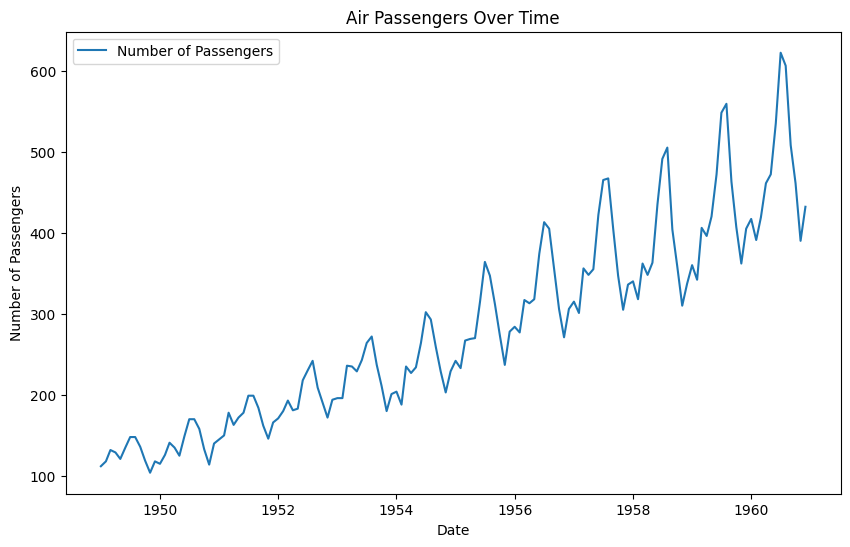

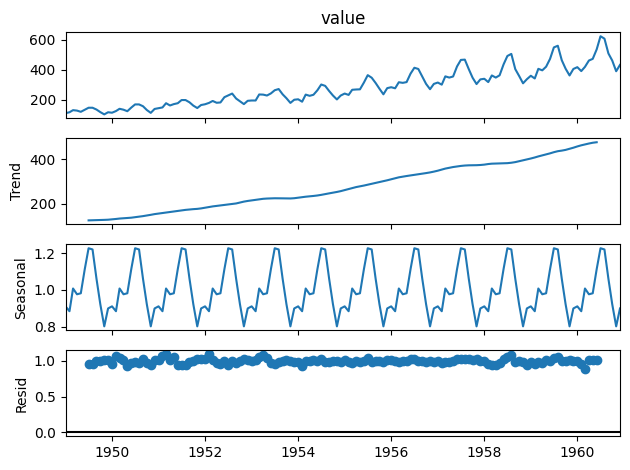

In [10]:
# Plot the data
plt.figure(figsize=(10,6))
plt.plot(df, label='Number of Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Air Passengers Over Time')
plt.legend()
plt.show()

# Decompose the time series
decomposition = seasonal_decompose(df['value'], model='multiplicative')
fig = decomposition.plot()
plt.show()


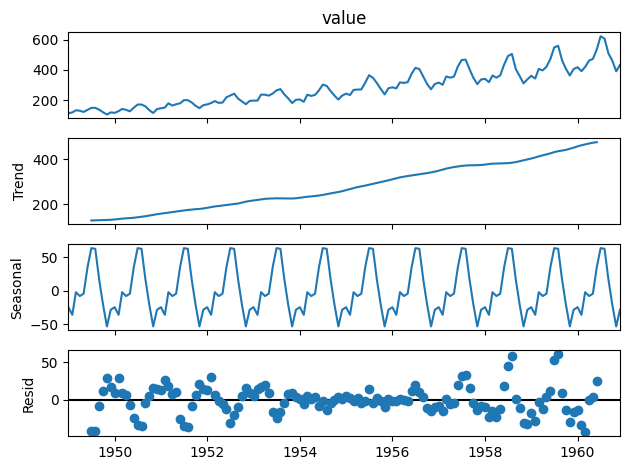

In [11]:
# Decompose the time series
decomposition = seasonal_decompose(df['value'], model='additive')
fig = decomposition.plot()
plt.show()

5. Stationarity Test

In [12]:
# Perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')

adf_test(df['value'])

ADF Statistic: 0.8153688792060457
p-value: 0.991880243437641
Critical Value 1%: -3.4816817173418295
Critical Value 5%: -2.8840418343195267
Critical Value 10%: -2.578770059171598


6. Differencing to Make Data Stationary

ADF Statistic: -2.8292668241699963
p-value: 0.05421329028382592
Critical Value 1%: -3.4816817173418295
Critical Value 5%: -2.8840418343195267
Critical Value 10%: -2.578770059171598


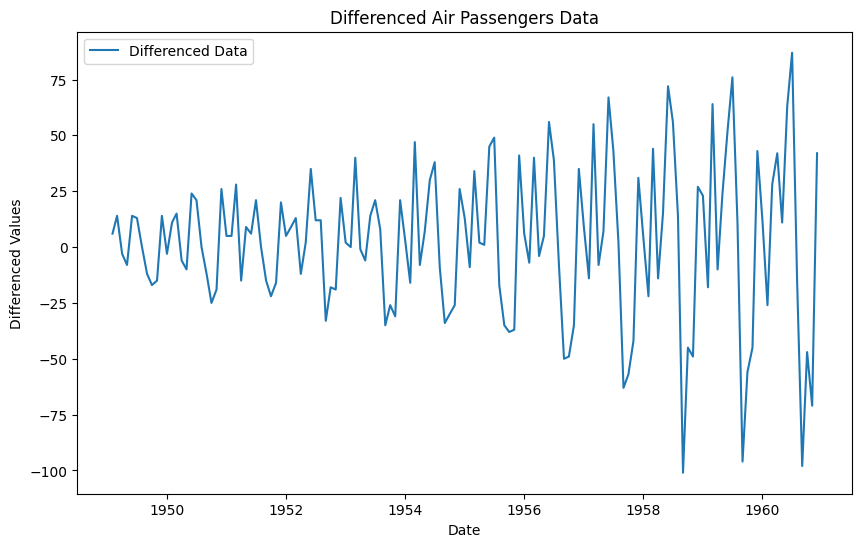

In [13]:
# Differencing the data
df_diff = df['value'].diff().dropna()
adf_test(df_diff)

plt.figure(figsize=(10,6))
plt.plot(df_diff, label='Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced Values')
plt.title('Differenced Air Passengers Data')
plt.legend()
plt.show()


7. Determine ARIMA Parameters (p, d, q)

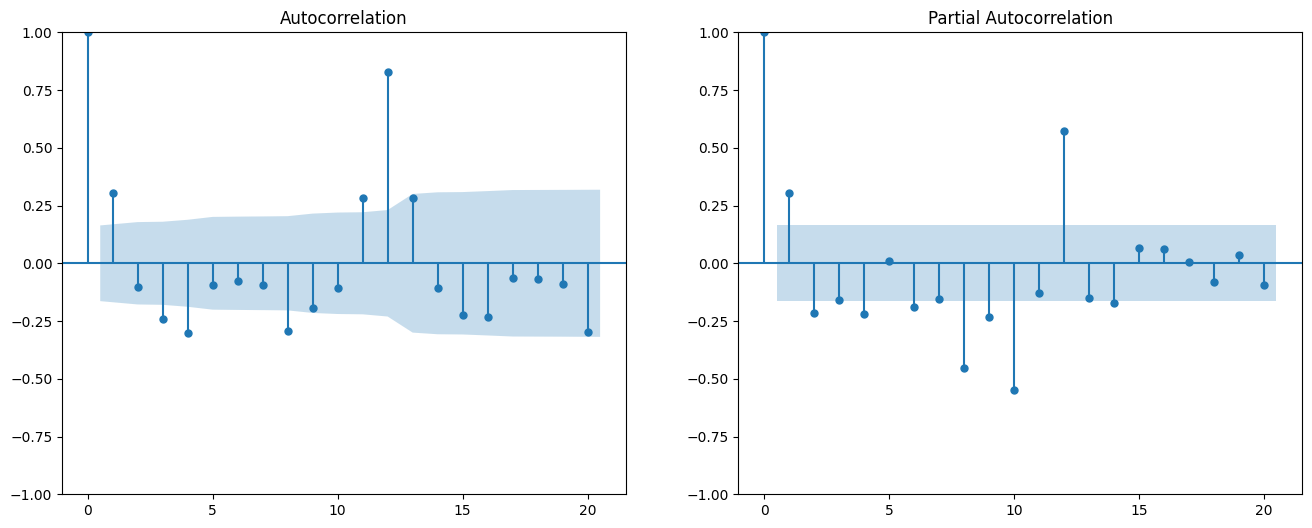

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_diff, lags=20, ax=axes[0])
plot_pacf(df_diff, lags=20, ax=axes[1])
plt.show()


8. Build and Train the ARIMA Model

In [19]:
# Fit ARIMA model
p,d,q=2,0,1
model = ARIMA(df['value'], order=(p, d, q))  # Replace p, d, q with determined values
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  144
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -699.125
Date:                Thu, 30 May 2024   AIC                           1408.250
Time:                        17:07:21   BIC                           1423.099
Sample:                    01-01-1949   HQIC                          1414.284
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3007     62.677      4.472      0.000     157.456     403.145
ar.L1          0.4990      0.131      3.822      0.000       0.243       0.755
ar.L2          0.4314      0.124      3.465      0.0

9. Model Diagnostics

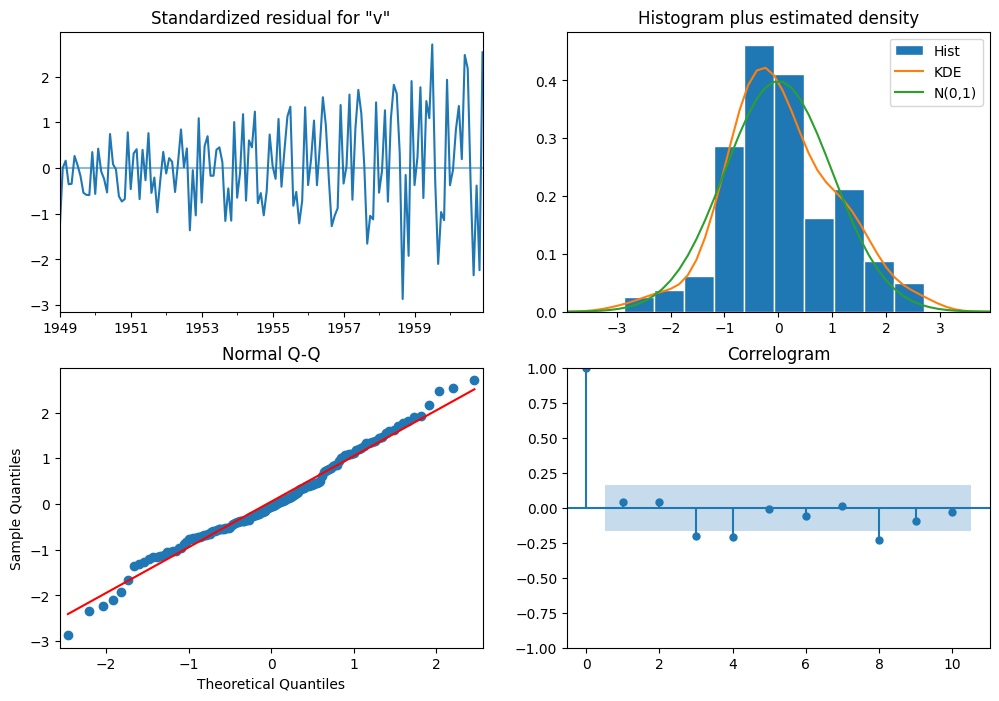

In [20]:
model_fit.plot_diagnostics(figsize=(12,8))
plt.show()


10. Forecasting

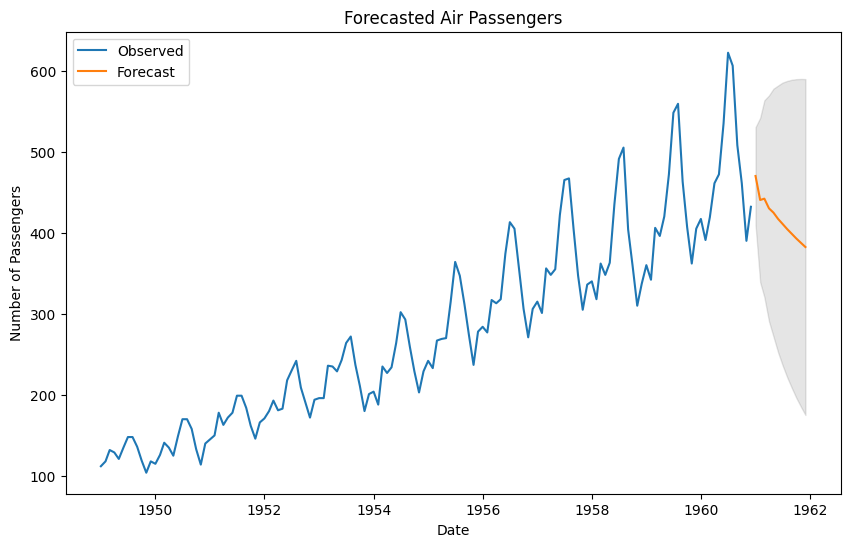

In [21]:
# Forecast
forecast_steps = 12  # Number of periods to forecast
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_df = forecast.conf_int()
forecast_df['forecast'] = model_fit.predict(start=forecast_df.index[0], end=forecast_df.index[-1])

# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(df, label='Observed')
plt.plot(forecast_df['forecast'], label='Forecast')
plt.fill_between(forecast_df.index, forecast_df.iloc[:, 0], forecast_df.iloc[:, 1], color='k', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Forecasted Air Passengers')
plt.legend()
plt.show()


11. Evaluate Model

In [ ]:
# If you have a test set
# test = ... (load your test set here)
# predictions = model_fit.forecast(steps=len(test))
# rmse = np.sqrt(mean_squared_error(test, predictions))
# print(f'RMSE: {rmse}')


12. Save and Deploy the Model

In [ ]:
# import joblib

# # Save the model
# joblib.dump(model_fit, 'arima_model.pkl')

# # Load the model (for deployment)
# loaded_model = joblib.load('arima_model.pkl')

# # Making future predictions with the loaded model
# future_forecast = loaded_model.get_forecast(steps=forecast_steps)
# future_forecast_df = future_forecast.conf_int()
# future_forecast_df['forecast'] = loaded_model.predict(start=future_forecast_df.index[0], end=future_forecast_df.index[-1])


# Simulate Multilevel Time Series Data

In [ ]:
import pandas as pd
import numpy as np

# Simulating data
np.random.seed(42)

date_range = pd.date_range(start='2020-01-01', end='2021-12-31', freq='M')
store_ids = ['Store_A', 'Store_B', 'Store_C']

data = {
    'Date': np.tile(date_range, len(store_ids)),
    'Store': np.repeat(store_ids, len(date_range)),
    'Sales': np.random.poisson(lam=200, size=len(date_range)*len(store_ids))
}

df = pd.DataFrame(data)
df.head()


2. Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


3. Data Cleaning

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values if any (for example, forward fill)
df.fillna(method='ffill', inplace=True)


4. Exploratory Data Analysis (EDA)

In [ ]:
# Plot the data
plt.figure(figsize=(14, 7))
for store in store_ids:
    store_data = df[df['Store'] == store]
    plt.plot(store_data['Date'], store_data['Sales'], label=store)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time for Different Stores')
plt.legend()
plt.show()


5. Stationarity Test and Differencing
We'll perform these steps for each store separately.

In [ ]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')

for store in store_ids:
    print(f'\nADF Test for {store}')
    store_data = df[df['Store'] == store]['Sales']
    adf_test(store_data)


If necessary, apply differencing:

In [ ]:
df_diff = pd.DataFrame()

for store in store_ids:
    store_data = df[df['Store'] == store]
    store_data['Sales_diff'] = store_data['Sales'].diff().dropna()
    df_diff = pd.concat([df_diff, store_data])

df_diff.dropna(inplace=True)

# Check stationarity after differencing
for store in store_ids:
    print(f'\nADF Test for {store} After Differencing')
    store_data = df_diff[df_diff['Store'] == store]['Sales_diff']
    adf_test(store_data)


6. Determine ARIMA Parameters (p, d, q)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for store in store_ids:
    store_data = df_diff[df_diff['Store'] == store]['Sales_diff']
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'ACF and PACF for {store}')
    plot_acf(store_data, lags=20, ax=axes[0])
    plot_pacf(store_data, lags=20, ax=axes[1])
    plt.show()


7. Build and Train the ARIMA Model

In [ ]:
models = {}
for store in store_ids:
    store_data = df[df['Store'] == store]['Sales']
    model = ARIMA(store_data, order=(p, d, q))  # Replace p, d, q with determined values
    model_fit = model.fit()
    models[store] = model_fit
    print(f'\nModel Summary for {store}')
    print(model_fit.summary())


8. Model Diagnostics

In [ ]:
for store, model_fit in models.items():
    print(f'\nDiagnostics for {store}')
    model_fit.plot_diagnostics(figsize=(12,8))
    plt.show()


9. Forecasting

In [ ]:
forecast_steps = 12  # Number of periods to forecast

for store, model_fit in models.items():
    forecast = model_fit.get_forecast(steps=forecast_steps)
    forecast_df = forecast.conf_int()
    forecast_df['forecast'] = model_fit.predict(start=forecast_df.index[0], end=forecast_df.index[-1])
    
    # Plot the forecast
    store_data = df[df['Store'] == store]
    plt.figure(figsize=(10,6))
    plt.plot(store_data['Date'], store_data['Sales'], label='Observed')
    plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast')
    plt.fill_between(forecast_df.index, forecast_df.iloc[:, 0], forecast_df.iloc[:, 1], color='k', alpha=0.1)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Forecasted Sales for {store}')
    plt.legend()
    plt.show()


10. Save and Deploy the Model

In [ ]:
import joblib

# Save models
for store, model_fit in models.items():
    joblib.dump(model_fit, f'arima_model_{store}.pkl')

# Load models and make future predictions
for store in store_ids:
    loaded_model = joblib.load(f'arima_model_{store}.pkl')
    future_forecast = loaded_model.get_forecast(steps=forecast_steps)
    future_forecast_df = future_forecast.conf_int()
    future_forecast_df['forecast'] = loaded_model.predict(start=future_forecast_df.index[0], end=future_forecast_df.index[-1])
    
    # Plot the forecast
    store_data = df[df['Store'] == store]
    plt.figure(figsize=(10,6))
    plt.plot(store_data['Date'], store_data['Sales'], label='Observed')
    plt.plot(future_forecast_df.index, future_forecast_df['forecast'], label='Forecast')
    plt.fill_between(future_forecast_df.index, future_forecast_df.iloc[:, 0], future_forecast_df.iloc[:, 1], color='k', alpha=0.1)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Future Forecasted Sales for {store}')
    plt.legend()
    plt.show()


# Multi Level time series model (combo time series models)

Note: This complete guide covers the implementation of multiple time series models for multilevel time series data, including ARIMA, SARIMA, ETS, Prophet, and LSTM. Each model is fitted to the data for each store, and forecasts are made for the next 12 months. The models are then saved for future deployment. Adjust the hyperparameters as needed based on your specific data and requirements.

Sure! Let's expand our multilevel time series analysis to include five different time series models. We'll use the following models:

- 1. ARIMA (AutoRegressive Integrated Moving Average)
- 2. SARIMA (Seasonal ARIMA)
- 3. Exponential Smoothing (ETS)
- 4. Prophet
- 5.  LSTM (Long Short-Term Memory) Neural Network

We'll implement each of these models for the multilevel time series problem. Below is the complete code:

1. Import Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings('ignore')


2. Simulate Multilevel Time Series Data

In [27]:
# Simulating data
np.random.seed(42)

date_range = pd.date_range(start='2020-01-01', end='2021-12-31', freq='M')
store_ids = ['Store_A', 'Store_B', 'Store_C']

data = {
    'Date': np.tile(date_range, len(store_ids)),
    'Store': np.repeat(store_ids, len(date_range)),
    'Sales': np.random.poisson(lam=200, size=len(date_range)*len(store_ids))
}

df = pd.DataFrame(data)
df.head()


,Date,Store,Sales
0,2020-01-31,Store_A,195
1,2020-02-29,Store_A,210
2,2020-03-31,Store_A,184
3,2020-04-30,Store_A,204
4,2020-05-31,Store_A,216


3. Data Cleaning

In [28]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values if any (for example, forward fill)
df.fillna(method='ffill', inplace=True)


Date     0
Store    0
Sales    0
dtype: int64


4. Exploratory Data Analysis (EDA)

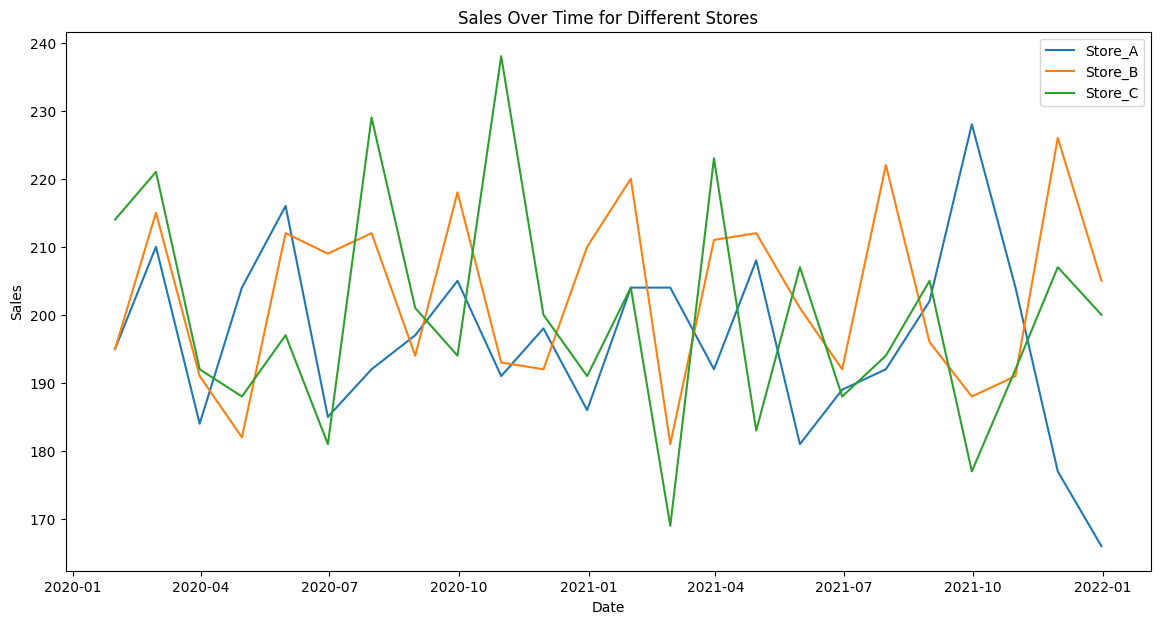

In [29]:
# Plot the data
plt.figure(figsize=(14, 7))
for store in store_ids:
    store_data = df[df['Store'] == store]
    plt.plot(store_data['Date'], store_data['Sales'], label=store)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time for Different Stores')
plt.legend()
plt.show()


5. Define Models

ARIMA Model

In [30]:
def fit_arima(df, store, order):
    store_data = df[df['Store'] == store]['Sales']
    model = ARIMA(store_data, order=order)
    model_fit = model.fit()
    return model_fit


SARIMA Model

In [31]:
def fit_sarima(df, store, order, seasonal_order):
    store_data = df[df['Store'] == store]['Sales']
    model = SARIMAX(store_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    return model_fit


Exponential Smoothing (ETS) Model

In [32]:
def fit_ets(df, store, seasonal_periods):
    store_data = df[df['Store'] == store]['Sales']
    model = ExponentialSmoothing(store_data, seasonal='add', seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    return model_fit


Prophet Model

In [33]:
def fit_prophet(df, store):
    store_data = df[df['Store'] == store][['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
    model = Prophet()
    model.fit(store_data)
    return model


LSTM Model

In [35]:
def fit_lstm(df, store, n_input, n_features=1, n_epochs=200):
    store_data = df[df['Store'] == store]['Sales'].values
    generator = TimeseriesGenerator(store_data, store_data, length=n_input, batch_size=1)
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    model.fit(generator, epochs=n_epochs, verbose=0)
    return model


6. Fit and Forecast with Each Model


We'll fit each model to the data for each store and forecast the next 12 months.


Forecasting for Store_A



18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing


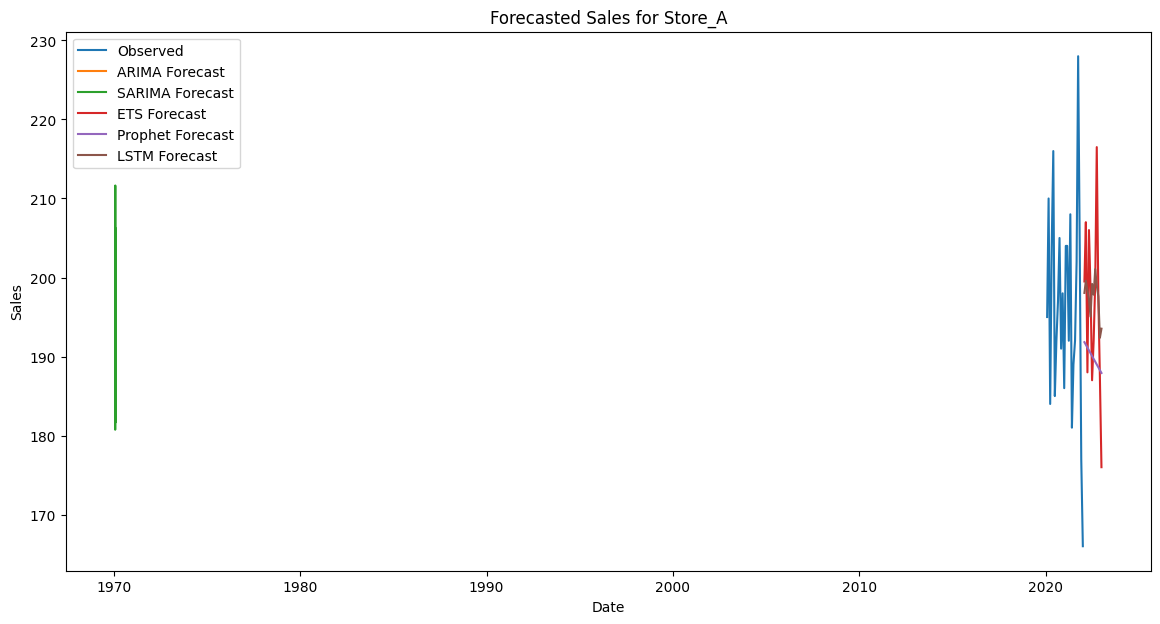


Forecasting for Store_B



18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing


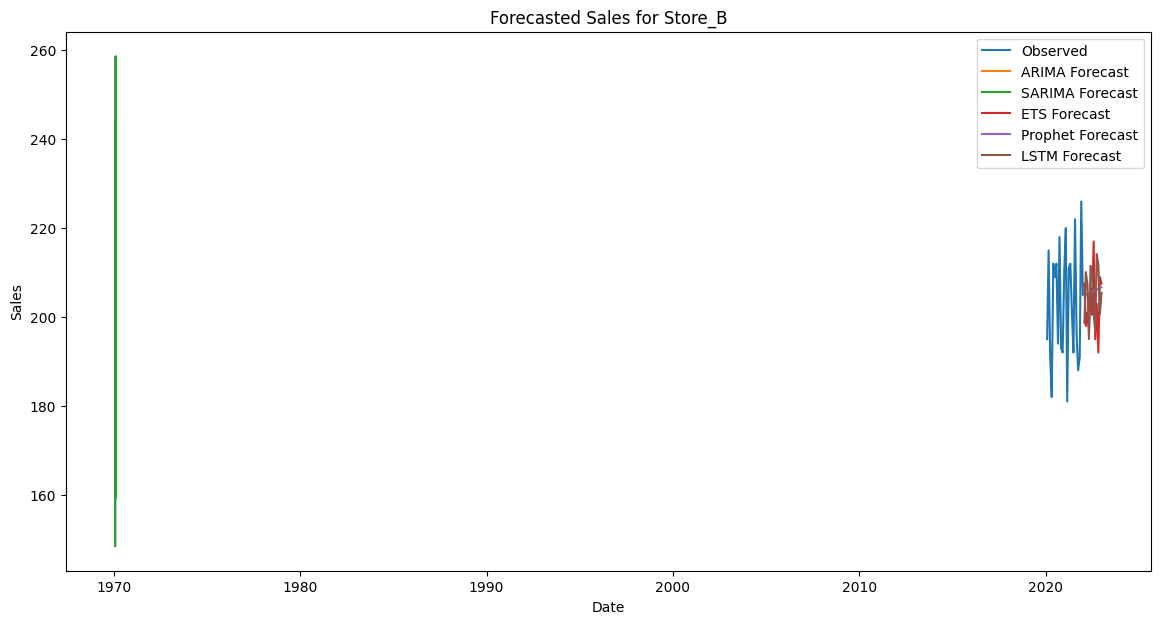


Forecasting for Store_C



18:05:05 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing


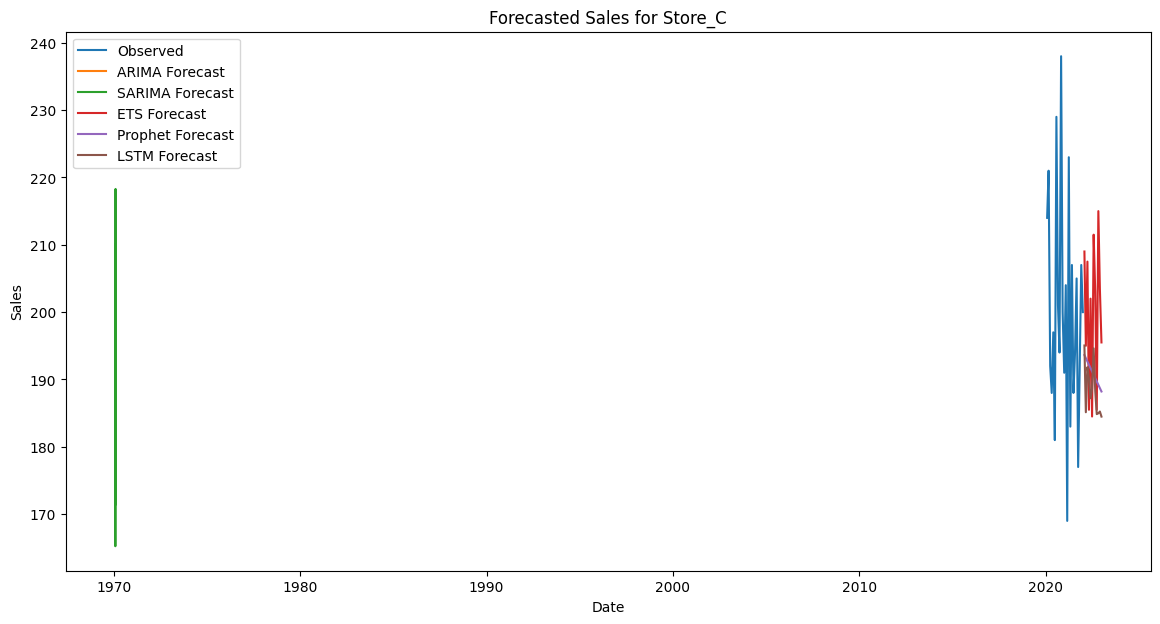

In [36]:
forecast_steps = 12

for store in store_ids:
    print(f'\nForecasting for {store}\n')

    # ARIMA
    arima_model = fit_arima(df, store, order=(1, 1, 1))
    arima_forecast = arima_model.get_forecast(steps=forecast_steps)
    arima_forecast_df = arima_forecast.conf_int()
    arima_forecast_df['forecast'] = arima_model.predict(start=arima_forecast_df.index[0], end=arima_forecast_df.index[-1])
    
    # SARIMA
    sarima_model = fit_sarima(df, store, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_forecast = sarima_model.get_forecast(steps=forecast_steps)
    sarima_forecast_df = sarima_forecast.conf_int()
    sarima_forecast_df['forecast'] = sarima_model.predict(start=sarima_forecast_df.index[0], end=sarima_forecast_df.index[-1])
    
    # ETS
    ets_model = fit_ets(df, store, seasonal_periods=12)
    ets_forecast = ets_model.forecast(steps=forecast_steps)
    
    # Prophet
    prophet_model = fit_prophet(df, store)
    future = pd.DataFrame(pd.date_range(start='2022-01-01', periods=forecast_steps, freq='M'), columns=['ds'])
    prophet_forecast = prophet_model.predict(future)
    
    # LSTM
    lstm_model = fit_lstm(df, store, n_input=12)
    lstm_forecast = []
    history = df[df['Store'] == store]['Sales'].values[-12:]
    for _ in range(forecast_steps):
        input_data = history[-12:].reshape((1, 12, 1))
        yhat = lstm_model.predict(input_data, verbose=0)
        lstm_forecast.append(yhat[0][0])
        history = np.append(history, yhat)
    
    # Plot forecasts
    plt.figure(figsize=(14, 7))
    store_data = df[df['Store'] == store]
    plt.plot(store_data['Date'], store_data['Sales'], label='Observed')
    plt.plot(arima_forecast_df.index, arima_forecast_df['forecast'], label='ARIMA Forecast')
    plt.plot(sarima_forecast_df.index, sarima_forecast_df['forecast'], label='SARIMA Forecast')
    plt.plot(pd.date_range(start='2022-01-01', periods=forecast_steps, freq='M'), ets_forecast, label='ETS Forecast')
    plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast')
    plt.plot(pd.date_range(start='2022-01-01', periods=forecast_steps, freq='M'), lstm_forecast, label='LSTM Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Forecasted Sales for {store}')
    plt.legend()
    plt.show()


7. Save and Deploy Models

In [ ]:
# import joblib

# # Save models
# for store in store_ids:
#     arima_model = fit_arima(df, store, order=(1, 1, 1))
#     joblib.dump(arima_model, f'arima_model_{store}.pkl')
    
#     sarima_model = fit_sarima(df, store, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
#     joblib.dump(sarima_model, f'sarima_model_{store}.pkl')
    
#     ets_model = fit_ets(df, store, seasonal_periods=12)
#     joblib.dump(ets_model, f'ets_model_{store}.pkl')
    
#     prophet_model = fit_prophet(df, store)
#     prophet_model.save(f'prophet_model_{store}.json')
    
#     lstm_model = fit_lstm(df, store, n_input=12)
#     lstm_model.save(f'lstm_model_{store}.h5')



Forecasting for Store_A



18:16:31 - cmdstanpy - INFO - Chain [1] start processing
18:16:31 - cmdstanpy - INFO - Chain [1] done processing


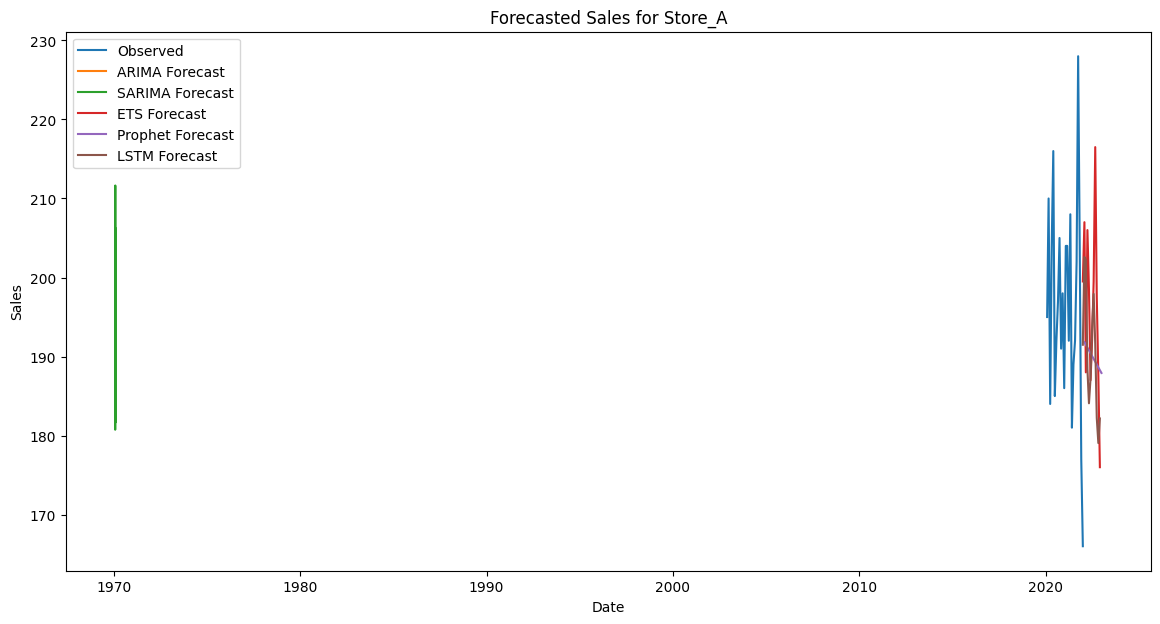


Forecasting for Store_B



18:16:58 - cmdstanpy - INFO - Chain [1] start processing
18:16:59 - cmdstanpy - INFO - Chain [1] done processing


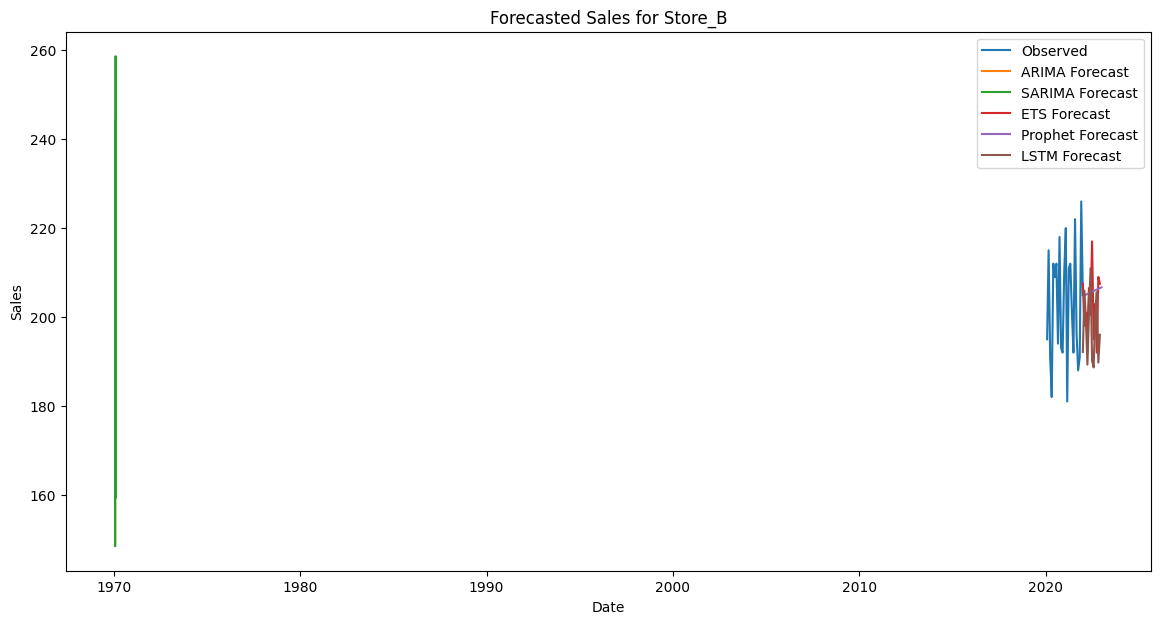


Forecasting for Store_C



18:17:25 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing


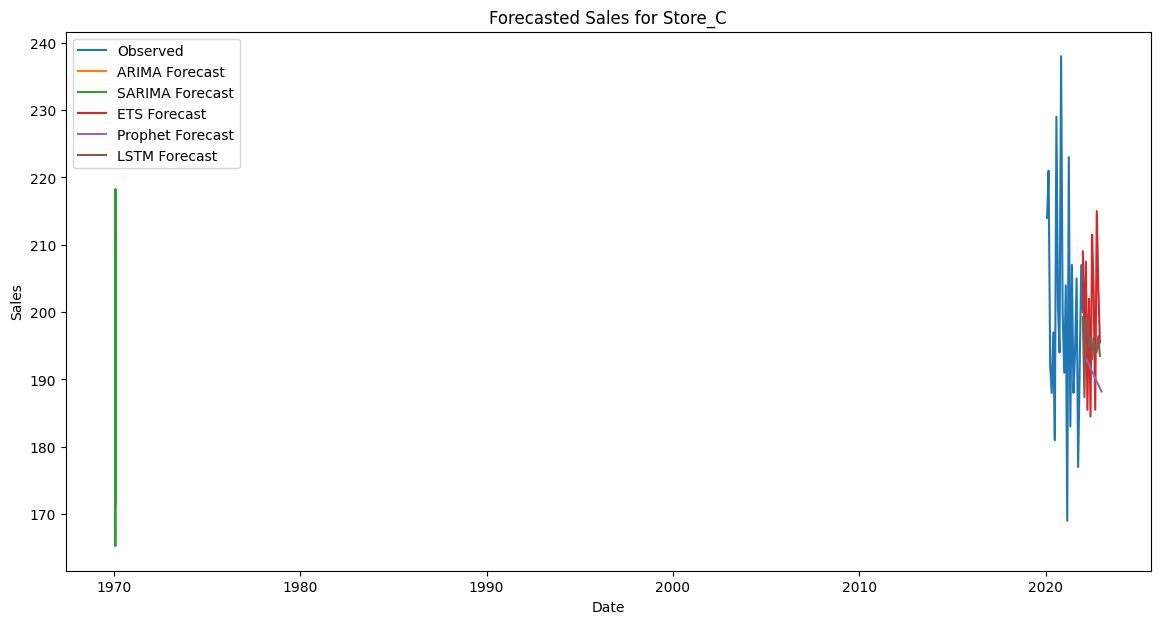

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings('ignore')

# Simulating data
np.random.seed(42)

date_range = pd.date_range(start='2020-01-01', end='2021-12-31', freq='M')
store_ids = ['Store_A', 'Store_B', 'Store_C']

data = {
    'Date': np.tile(date_range, len(store_ids)),
    'Store': np.repeat(store_ids, len(date_range)),
    'Sales': np.random.poisson(lam=200, size=len(date_range)*len(store_ids))
}

df = pd.DataFrame(data)

# Data Cleaning
df.fillna(method='ffill', inplace=True)

# Define Models
def fit_arima(df, store, order):
    store_data = df[df['Store'] == store]['Sales']
    model = ARIMA(store_data, order=order)
    model_fit = model.fit()
    return model_fit

def fit_sarima(df, store, order, seasonal_order):
    store_data = df[df['Store'] == store]['Sales']
    model = SARIMAX(store_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    return model_fit

def fit_ets(df, store, seasonal_periods):
    store_data = df[df['Store'] == store]['Sales']
    model = ExponentialSmoothing(store_data, seasonal='add', seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    return model_fit

def fit_prophet(df, store):
    store_data = df[df['Store'] == store][['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
    model = Prophet()
    model.fit(store_data)
    return model

def fit_lstm(df, store, n_input, n_features=1, n_epochs=200):
    store_data = df[df['Store'] == store]['Sales'].values
    generator = TimeseriesGenerator(store_data, store_data, length=n_input, batch_size=1)
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    model.fit(generator, epochs=n_epochs, verbose=0)
    return model

# Fit and Forecast with Each Model
forecast_steps = 12

for store in store_ids:
    print(f'\nForecasting for {store}\n')

    # ARIMA
    arima_model = fit_arima(df, store, order=(1, 1, 1))
    arima_forecast = arima_model.get_forecast(steps=forecast_steps)
    arima_forecast_df = arima_forecast.conf_int()
    arima_forecast_df['forecast'] = arima_model.predict(start=arima_forecast_df.index[0], end=arima_forecast_df.index[-1])
    arima_forecast_df.index.name = 'Date'

    # SARIMA
    sarima_model = fit_sarima(df, store, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_forecast = sarima_model.get_forecast(steps=forecast_steps)
    sarima_forecast_df = sarima_forecast.conf_int()
    sarima_forecast_df['forecast'] = sarima_model.predict(start=sarima_forecast_df.index[0], end=sarima_forecast_df.index[-1])
    sarima_forecast_df.index.name = 'Date'

    # ETS
    ets_model = fit_ets(df, store, seasonal_periods=12)
    ets_forecast = ets_model.forecast(steps=forecast_steps)
    ets_forecast_index = pd.date_range(start=df['Date'].max(), periods=forecast_steps, freq='M')

    # Prophet
    prophet_model = fit_prophet(df, store)
    future = pd.DataFrame(pd.date_range(start=df['Date'].max() + pd.DateOffset(1), periods=forecast_steps, freq='M'), columns=['ds'])
    prophet_forecast = prophet_model.predict(future)
    prophet_forecast = prophet_forecast[['ds', 'yhat']].set_index('ds')

    # LSTM
    lstm_model = fit_lstm(df, store, n_input=12)
    lstm_forecast = []
    history = df[df['Store'] == store]['Sales'].values[-12:]
    for _ in range(forecast_steps):
        input_data = history[-12:].reshape((1, 12, 1))
        yhat = lstm_model.predict(input_data, verbose=0)
        lstm_forecast.append(yhat[0][0])
        history = np.append(history, yhat)
    lstm_forecast_index = pd.date_range(start=df['Date'].max(), periods=forecast_steps, freq='M')

    # Plot forecasts
    plt.figure(figsize=(14, 7))
    store_data = df[df['Store'] == store]
    plt.plot(store_data['Date'], store_data['Sales'], label='Observed')
    plt.plot(arima_forecast_df.index, arima_forecast_df['forecast'], label='ARIMA Forecast')
    plt.plot(sarima_forecast_df.index, sarima_forecast_df['forecast'], label='SARIMA Forecast')
    plt.plot(ets_forecast_index, ets_forecast, label='ETS Forecast')
    plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet Forecast')
    plt.plot(lstm_forecast_index, lstm_forecast, label='LSTM Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Forecasted Sales for {store}')
    plt.legend()
    plt.show()
